In [1]:
import os
import numpy as np
import logging
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 设置日志记录器
logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')

# 加载单个图像的函数
def load_image(img_id, rawdata_dir):
    img_path = os.path.join(rawdata_dir, f'{img_id}')
    try:
        with open(img_path, 'rb') as img_file:
            img_data = np.frombuffer(img_file.read(), dtype=np.uint8)
        if img_data.size == 16384:
            img_matrix = img_data.reshape((128, 128))
            return img_matrix
        else:
            # 记录错误信息并返回一个占位图像（全黑图像）
            logging.error(f"Expected 16384 bytes for image {img_id}, but got {img_data.size}. Using a placeholder image.")
            placeholder_image = np.zeros((128, 128), dtype=np.uint8)
            return placeholder_image
    except Exception as e:
        # 记录无法读取文件时的错误信息并返回一个占位图像
        logging.error(f"Failed to load image {img_id} from {img_path}: {e}")
        placeholder_image = np.zeros((128, 128), dtype=np.uint8)
        return placeholder_image

# 读取数据的函数
def load_data(filepath, rawdata_dir):
    data = []
    labels = []
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split()
            img_id = int(parts[0])
            gender = parts[1]
            age = parts[2]
            image = load_image(img_id, rawdata_dir)  # 使用 load_image 函数加载图像
            data.append(image.flatten())  # 展平为向量
            labels.append((gender, age))
    return np.array(data), labels

# 加载数据
rawdata_dir = 'rawdata'  # 替换为您的原始数据目录路径
labels_filepath = 'cleared_faceDS.txt'  # 替换为您的标签文件路径
data, labels = load_data(labels_filepath, rawdata_dir)

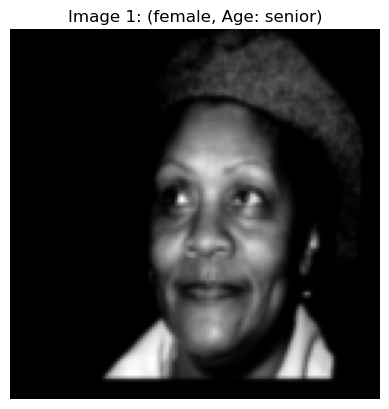

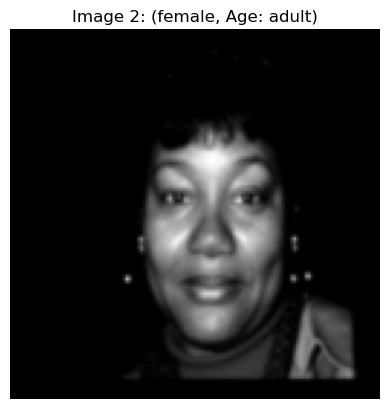

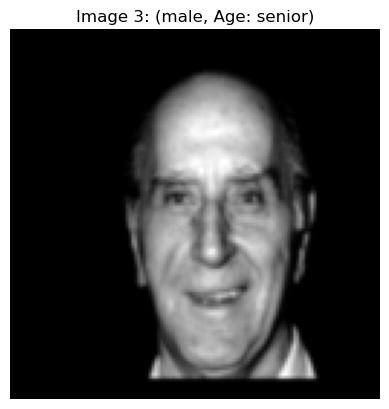

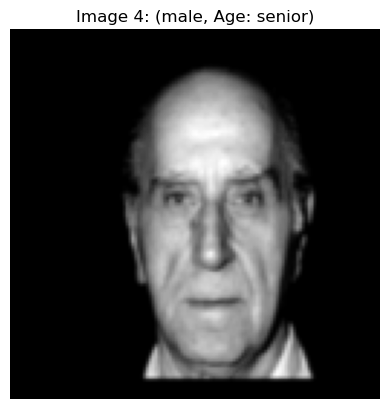

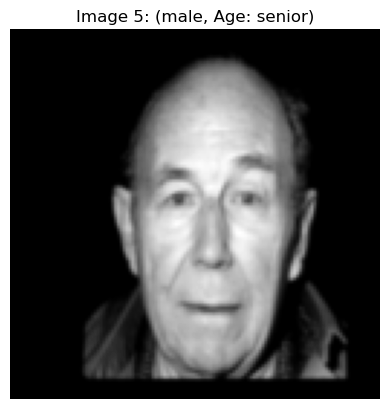

In [3]:
# 显示部分数据
for i in range(5):  # 显示前5个图像作为示例
    image_data = data[i]
    # 检查是否为占位图像（全黑图像）
    if np.all(image_data.reshape((128, 128)) == 0):
        # 提取图像ID
        img_id_str = labels[i][0].split('_')[0] if '_' in labels[i][0] else labels[i][0]
        title = f'Image {i+1}: Placeholder (Error loading image {img_id_str})'
    else:
        title = f'Image {i+1}: {labels[i][0]}, Age: {labels[i][1]}'
    plt.imshow(image_data.reshape((128, 128)), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [5]:
# 加载训练和测试数据
train_data, train_labels = load_data('cleared_faceDR.txt', 'rawdata')
test_data, test_labels = load_data('cleared_faceDS.txt', 'rawdata')

# 数据归一化
def normalize_data(data):
    return (data / 255.0).astype(np.float32)
 
# 在加载数据后进行归一化
train_data = normalize_data(train_data)
test_data = normalize_data(test_data)

# 标签编码
gender_encoder = LabelEncoder()
age_encoder = LabelEncoder()
train_gender_labels = gender_encoder.fit_transform([label[0] for label in train_labels])
train_age_labels = age_encoder.fit_transform([label[1] for label in train_labels])
test_gender_labels = gender_encoder.transform([label[0] for label in test_labels])
test_age_labels = age_encoder.transform([label[1] for label in test_labels])

2025-01-09 19:57:28,366 - ERROR - Expected 16384 bytes for image 2412, but got 262144. Using a placeholder image.
2025-01-09 19:57:28,373 - ERROR - Expected 16384 bytes for image 2416, but got 262144. Using a placeholder image.


In [7]:
# 合并所有训练数据
X_train_all = np.array(train_data)

# PCA降维
n_components = 150  # 可以调整
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_all)

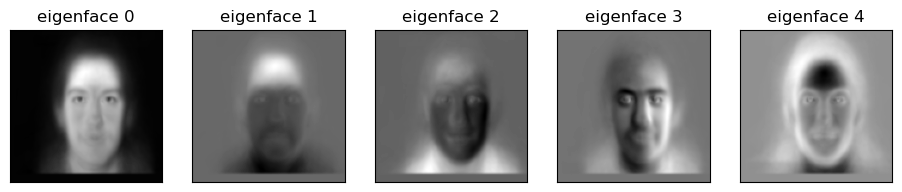

In [9]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# 获取特征脸（eigenfaces）
eigenfaces = pca.components_
h, w = 128, 128
 
# 使用plot_gallery函数显示前五幅特征脸
eigenface_titles = ["eigenface %d" % i for i in range(5)]  # 只显示前五幅
plot_gallery(eigenfaces[:5], eigenface_titles, h, w, n_row=1, n_col=5)  # 调整n_row和n_col以适应显示的图像数量
 
plt.show()

Best parameters for gender classification: {'C': 10000.0, 'gamma': 1e-05}
Cross-validation scores for gender classification: [0.4725     0.7975     0.7593985  0.88721805 0.78195489]
Mean cross-validation score for gender classification: 0.7397142857142857
Best parameters for age classification: {'C': 1000.0, 'gamma': 0.001}
Cross-validation scores for age classification: [0.5175     0.8525     0.88972431 0.79949875 0.79699248]
Mean cross-validation score for age classification: 0.7712431077694235
              precision    recall  f1-score   support

     (female       0.63      0.60      0.61       719
       (male       0.78      0.80      0.79      1277

    accuracy                           0.73      1996
   macro avg       0.70      0.70      0.70      1996
weighted avg       0.72      0.73      0.73      1996

Test Accuracy for Gender Classification: 0.7270
              precision    recall  f1-score   support

      adult)       0.89      0.94      0.91      1730
      child)  

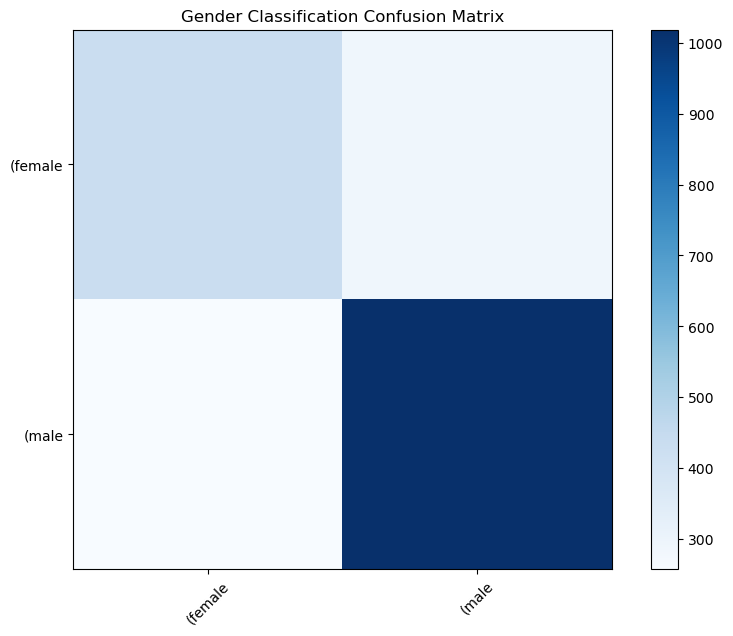

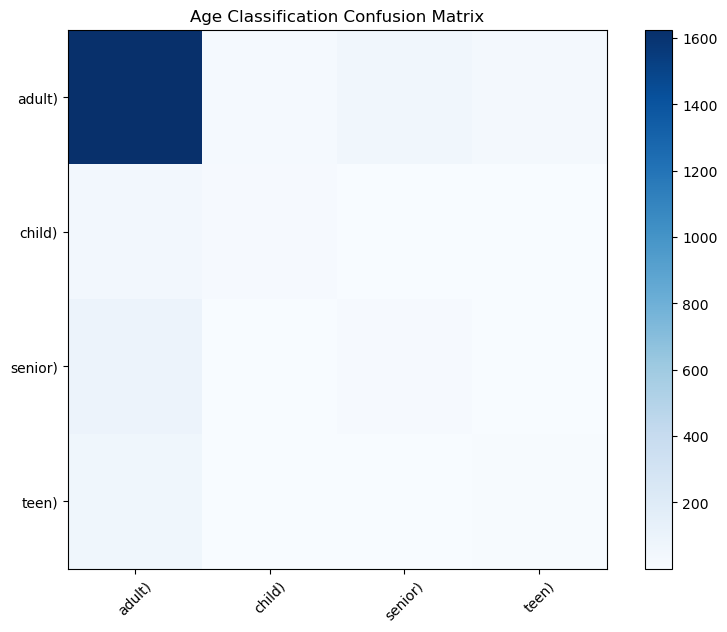

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 计算每个类的样本数
n_samples_gender = np.bincount(train_gender_labels)
n_samples_age = np.bincount(train_age_labels)

# 计算每个类的权重（样本数的倒数，然后归一化）
weight_gender = (1 / n_samples_gender) / np.sum(1 / n_samples_gender)
weight_age = (1 / n_samples_age) / np.sum(1 / n_samples_age)

# 将权重转换为字典格式，适用于SVC的class_weight参数
class_weight_gender = {i: w for i, w in enumerate(weight_gender)}
class_weight_age = {i: w for i, w in enumerate(weight_age)}

# 参数网格
param_grid = {
    'C': [1e2, 1e3, 1e4],
    'gamma': [1e-3, 1e-4, 1e-5],
}

# 性别分类交叉验证，包含类权重
grid_search_gender = GridSearchCV(SVC(kernel='rbf', class_weight=class_weight_gender), param_grid, cv=5, scoring='accuracy')
grid_search_gender.fit(X_train_pca, train_gender_labels)
print("Best parameters for gender classification:", grid_search_gender.best_params_)
clf_gender = grid_search_gender.best_estimator_

# 使用最佳参数进行性别分类交叉验证评估
gender_cv_scores = cross_val_score(clf_gender, X_train_pca, train_gender_labels, cv=5)
print("Cross-validation scores for gender classification:", gender_cv_scores)
print("Mean cross-validation score for gender classification:", np.mean(gender_cv_scores))

# 年龄分类交叉验证，包含类权重
grid_search_age = GridSearchCV(SVC(kernel='rbf', class_weight=class_weight_age), param_grid, cv=5, scoring='accuracy')
grid_search_age.fit(X_train_pca, train_age_labels)
print("Best parameters for age classification:", grid_search_age.best_params_)
clf_age = grid_search_age.best_estimator_

# 使用最佳参数进行年龄分类交叉验证评估
age_cv_scores = cross_val_score(clf_age, X_train_pca, train_age_labels, cv=5)
print("Cross-validation scores for age classification:", age_cv_scores)
print("Mean cross-validation score for age classification:", np.mean(age_cv_scores))

# 测试数据PCA转换
X_test_pca = pca.transform(test_data)

# 测试性别分类并计算准确率
y_test_gender_pred = clf_gender.predict(X_test_pca)
gender_classification_report = classification_report(test_gender_labels, y_test_gender_pred, target_names=gender_encoder.classes_)
print(gender_classification_report)
gender_accuracy = accuracy_score(test_gender_labels, y_test_gender_pred)
print(f"Test Accuracy for Gender Classification: {gender_accuracy:.4f}")

# 测试年龄分类并计算准确率
y_test_age_pred = clf_age.predict(X_test_pca)
age_classification_report = classification_report(test_age_labels, y_test_age_pred, target_names=age_encoder.classes_)
print(age_classification_report)
age_accuracy = accuracy_score(test_age_labels, y_test_age_pred)
print(f"Test Accuracy for Age Classification: {age_accuracy:.4f}")

# 性别分类混淆矩阵
conf_matrix_gender = confusion_matrix(test_gender_labels, y_test_gender_pred)
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix_gender, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Gender Classification Confusion Matrix')
plt.xticks(range(len(gender_encoder.classes_)), gender_encoder.classes_, rotation=45)
plt.yticks(range(len(gender_encoder.classes_)), gender_encoder.classes_)
plt.colorbar()
plt.show()

# 年龄分类混淆矩阵
conf_matrix_age = confusion_matrix(test_age_labels, y_test_age_pred)
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix_age, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Age Classification Confusion Matrix')
plt.xticks(range(len(age_encoder.classes_)), age_encoder.classes_, rotation=45)
plt.yticks(range(len(age_encoder.classes_)), age_encoder.classes_)
plt.colorbar()
plt.show()

In [7]:
# 对比：没有重加权
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

# 参数网格
param_grid = {
    'C': [1e2, 1e3, 1e4],
    'gamma': [1e-3, 1e-4, 1e-5],
}
 
# 性别分类交叉验证
grid_search_gender = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')
grid_search_gender.fit(X_train_pca, train_gender_labels)
print("Best parameters for gender classification:", grid_search_gender.best_params_)
clf_gender = grid_search_gender.best_estimator_
 
# 使用最佳参数进行性别分类交叉验证评估
best_clf_gender = grid_search_gender.best_estimator_
gender_cv_scores = cross_val_score(best_clf_gender, X_train_pca, train_gender_labels, cv=5)
print("Cross-validation scores for gender classification:", gender_cv_scores)
print("Mean cross-validation score for gender classification:", np.mean(gender_cv_scores))
 
# 年龄分类交叉验证
grid_search_age = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')
grid_search_age.fit(X_train_pca, train_age_labels)
print("Best parameters for age classification:", grid_search_age.best_params_)
clf_age = grid_search_age.best_estimator_
 
# 使用最佳参数进行年龄分类交叉验证评估
best_clf_age = grid_search_age.best_estimator_
age_cv_scores = cross_val_score(best_clf_age, X_train_pca, train_age_labels, cv=5)
print("Cross-validation scores for age classification:", age_cv_scores)
print("Mean cross-validation score for age classification:", np.mean(age_cv_scores))

Best parameters for gender classification: {'C': 10000.0, 'gamma': 1e-05}
Cross-validation scores for gender classification: [0.48       0.795      0.79699248 0.86967419 0.76942356]
Mean cross-validation score for gender classification: 0.7422180451127819
Best parameters for age classification: {'C': 1000.0, 'gamma': 0.001}
Cross-validation scores for age classification: [0.5475     0.835      0.85964912 0.77694236 0.76691729]
Mean cross-validation score for age classification: 0.7572017543859648


In [9]:
from sklearn.metrics import accuracy_score

# 测试数据PCA转换
X_test_pca = pca.transform(np.array(test_data))

# 测试性别分类并计算准确率
y_test_gender_pred = clf_gender.predict(X_test_pca)
gender_classification_report = classification_report(test_gender_labels, y_test_gender_pred, target_names=gender_encoder.classes_)
print(gender_classification_report)
gender_accuracy = accuracy_score(test_gender_labels, y_test_gender_pred)
print(f"Test Accuracy for Gender Classification: {gender_accuracy:.4f}")

# 测试年龄分类并计算准确率
y_test_age_pred = clf_age.predict(X_test_pca)
age_classification_report = classification_report(test_age_labels, y_test_age_pred, target_names=age_encoder.classes_)
print(age_classification_report)
age_accuracy = accuracy_score(test_age_labels, y_test_age_pred)
print(f"Test Accuracy for Age Classification: {age_accuracy:.4f}")

              precision    recall  f1-score   support

     (female       0.64      0.57      0.60       719
       (male       0.77      0.82      0.80      1277

    accuracy                           0.73      1996
   macro avg       0.71      0.69      0.70      1996
weighted avg       0.72      0.73      0.73      1996

Test Accuracy for Gender Classification: 0.7300
              precision    recall  f1-score   support

      adult)       0.89      0.94      0.91      1730
      child)       0.38      0.19      0.25        68
     senior)       0.22      0.17      0.20       115
       teen)       0.19      0.13      0.16        83

    accuracy                           0.83      1996
   macro avg       0.42      0.36      0.38      1996
weighted avg       0.81      0.83      0.82      1996

Test Accuracy for Age Classification: 0.8337


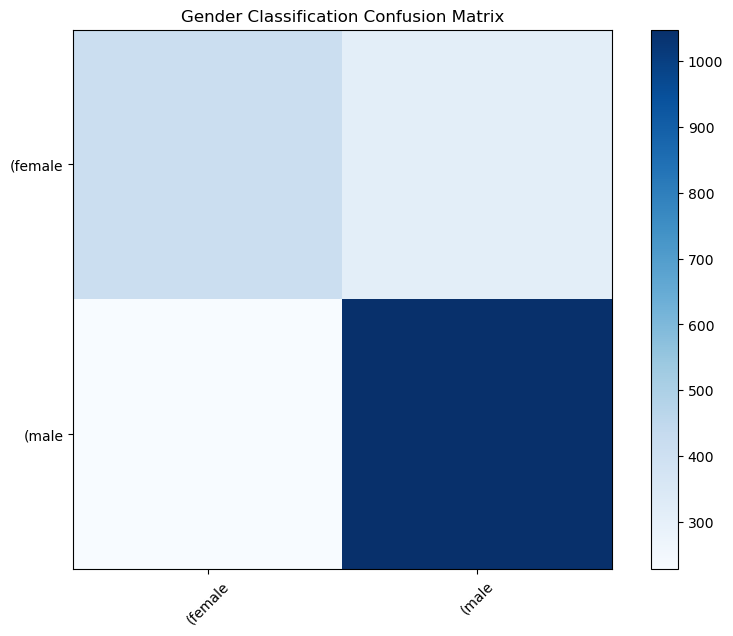

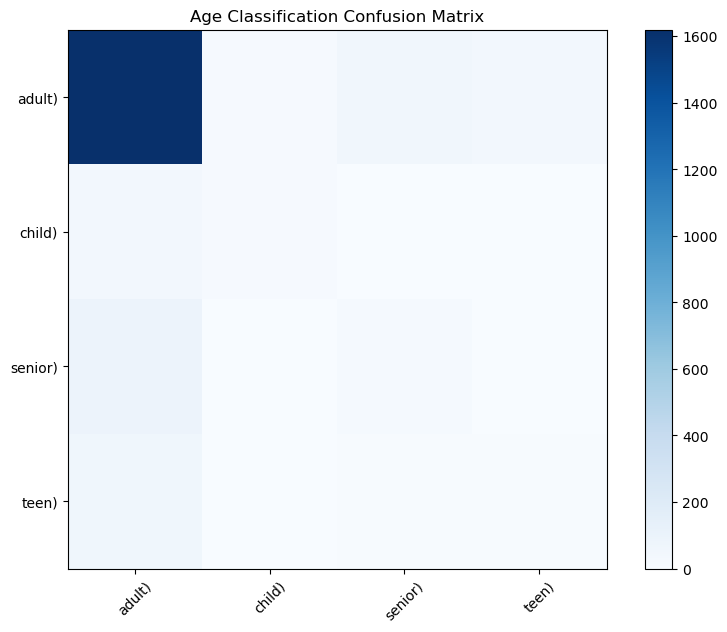

In [11]:
# 性别分类混淆矩阵
conf_matrix_gender = confusion_matrix(test_gender_labels, y_test_gender_pred)
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix_gender, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Gender Classification Confusion Matrix')
plt.xticks(range(len(gender_encoder.classes_)), gender_encoder.classes_, rotation=45)
plt.yticks(range(len(gender_encoder.classes_)), gender_encoder.classes_)
plt.colorbar()
plt.show()

# 年龄分类混淆矩阵
conf_matrix_age = confusion_matrix(test_age_labels, y_test_age_pred)
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix_age, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Age Classification Confusion Matrix')
plt.xticks(range(len(age_encoder.classes_)), age_encoder.classes_, rotation=45)
plt.yticks(range(len(age_encoder.classes_)), age_encoder.classes_)
plt.colorbar()
plt.show()